In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

### SIS process

In [7]:
N = 10
beta=2 #infection rate
gamma=0.5 #recovery rate, =0.5  infection survives vs =1.5 dies out

# sparse rate matrix
Q = np.zeros((N+1,N+1))
for i in range(N+1):
    if i<N:
        Q[i,i+1] = beta*(1/N)*(i)*(N-i)
    if i>0:
        Q[i,i-1] = gamma* i
    Q[i,i] = - np.sum(Q[i,:])

# jump matrix
P = Q-np.diag(np.diag(Q))
zerorows = np.where(np.diag(Q)==0)
P[zerorows,zerorows]=1
P = P/np.sum(P,axis=1)[:,np.newaxis]

Q

array([[ -0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [  1.5,  -3.3,   1.8,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [  0. ,   3. ,  -6.2,   3.2,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [  0. ,   0. ,   4.5,  -8.7,   4.2,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [  0. ,   0. ,   0. ,   6. , -10.8,   4.8,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   7.5, -12.5,   5. ,   0. ,   0. ,
          0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   9. , -13.8,   4.8,   0. ,
          0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  10.5, -14.7,   4.2,
          0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  12. , -15.2,
          3.2,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  13.5,
        -15.3,   1.8],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0

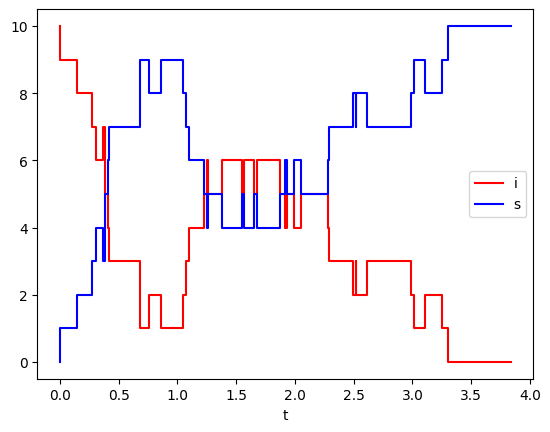

In [10]:
N_jumps = 200

jumptimes = np.zeros(N_jumps)
jumptimes[0] = 0
jumploc = np.zeros(N_jumps)
jumploc[0] = 10 #start location

index_diedout = N_jumps

for i in range(1,N_jumps):
    st = int(jumploc[i-1]) #current state
    if st==0:
        index_diedout=i
        break
        
    intereventtime = np.random.exponential(-1/np.diag(Q)[st])
    jumptimes[i] = jumptimes[i-1] + intereventtime
    choosestate = np.random.choice(np.arange(N+1), p=P[st])
    jumploc[i] = choosestate.copy()

plt.step(jumptimes[:index_diedout], jumploc[:index_diedout],'r',label='i')
plt.step(jumptimes[:index_diedout], N-jumploc[:index_diedout],'b',label='s')
plt.xlabel('t')
plt.legend()

### Evolution of distributions




Text(0, 0.5, '$X_t$')

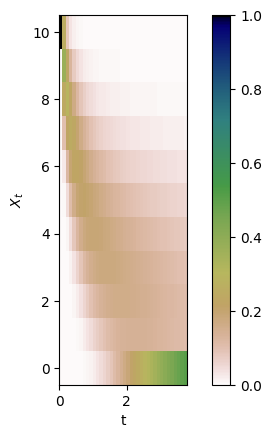

In [11]:
dt = 0.1
N_timesteps = int(jumptimes[index_diedout-1]/dt)

dist= np.zeros((N_timesteps, N+1))
# all traj start in state 10
dist[0,10]=1

P = sp.linalg.expm(dt*Q)
for i in range(1,N_timesteps):
    dist[i,:] = np.dot(dist[i-1,:],P)

plt.imshow(dist.T,origin="lower",extent = (0,dt*N_timesteps,-0.5,N+0.5),cmap = "gist_earth_r",clim = (0,1)) 
plt.colorbar()
plt.xlabel("t")
plt.ylabel("$X_t$")

Text(0, 0.5, '$X_t$')

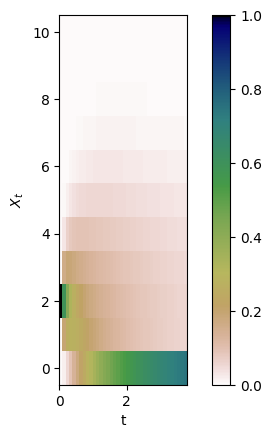

In [12]:
dist= np.zeros((N_timesteps, N+1))
# uniform initial distribution
dist[0,2]=1

P = sp.linalg.expm(dt*Q)
for i in range(1,N_timesteps):
    dist[i,:] = np.dot(dist[i-1,:],P)

plt.imshow(dist.T,origin="lower",extent = (0,dt*N_timesteps,-0.5,N+0.5),cmap = "gist_earth_r",clim = (0,1))
plt.colorbar()
plt.xlabel("t")
plt.ylabel("$X_t$")

### SIS on a network

In [19]:
N = 10
beta=2
gamma=0.5 #0.5 vs 1.5

# line network
A = np.zeros((N,N))
for i in range(1,N-1):
    A[i,i+1]=1
    A[i,i-1]=1
A[0,1] = 1
A[N-1,N-2] = 1

A

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

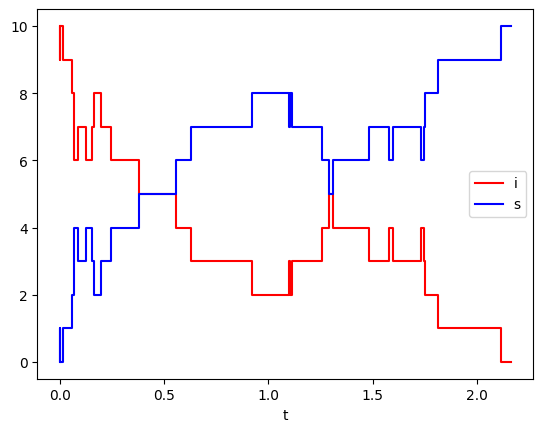

In [23]:
jumptimes = np.zeros(N_jumps)
jumptimes[0] = 0
jumploc = np.zeros((N_jumps,N))
init = np.ones(N) #all infected
jumploc[0,:] = init #start location


index_diedout = N_jumps
# rate for each agent to switch, either to get infected or to recover
rates = np.zeros(N)
for i in range(1,N_jumps):
    st = jumploc[i-1,:] #current state
    if np.isclose(np.sum(st),0): #check if infection has died out
        index_diedout=i
        break
    for j in range(N):
        if st[j] == 0: #susceptible
            rates[j] = beta* np.dot(A[j,:], st)/np.sum(A[j,:])
        elif st[j]==1: #infected
            rates[j]= gamma
    intereventtime = np.random.exponential(1/np.sum(rates))
    jumptimes[i] = jumptimes[i-1] + intereventtime
    choosestate = np.random.choice(np.arange(N), p=rates/np.sum(rates))
    jumploc[i,:] = st.copy()
    jumploc[i,choosestate] = 1-jumploc[i,choosestate]

summed_jumploc = np.sum(jumploc, axis=1)
plt.step(jumptimes[:index_diedout], summed_jumploc[:index_diedout],'r',label='i')
plt.step(jumptimes[:index_diedout], N-summed_jumploc[:index_diedout],'b',label='s')
plt.xlabel('t')
plt.legend()

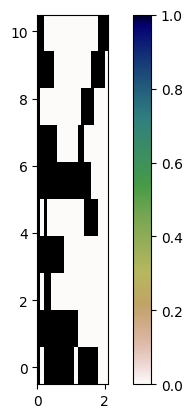

In [24]:
N_timesteps = int(jumptimes[index_diedout-1]/dt)
states= np.zeros((N_timesteps, N))
 
for i in range(0,N_timesteps):
    index =  np.argmin(np.abs(jumptimes[:index_diedout] - dt*i))
    states[i,:] = jumploc[index,:]

plt.imshow(states.T,origin="lower",extent = (0,dt*N_timesteps,-0.5,N+0.5),cmap = "gist_earth_r",clim = (0,1),interpolation='none')
plt.colorbar()